In [ ]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [18]:
#read event dataset
import gzip
with gzip.open("GameAnalyticsTestData.gz") as f:
    event_df = pd.read_csv(f)
event_df.head()

,event_timestamp,event_category,event_id,player_country_code,player_id,player_session_id,transaction_amount,game_build,player_first_install_timestamp,session_start_ts,session_duration_seconds,player_cumulative_revenue
0,1484053435,design,boot,TR,7a98917fd12ba24ae4d2e42a74b0944c,01l7esFo-5XvS-eyKl-QX5q-UalaTmyM2qz,nan,v1.1.26,1483818916,1484053428,310,nan
1,1484416837,design,boot,IT,20fbf618e34215d876965b6304134ce3,03PPdJ8G-Hn6V-5zwl-xRZx-3k06wnFhxqH,nan,v1.1.26,1484416849,1484416835,14,nan
2,1484148932,design,boot,NaN,c44c05baf6f019241780cca1947e8cc2,03qZsL5V-m8MH-ybBT-PX6w-K83AOfIWnek,nan,v1.1.28,1482771340,1484148925,8783,nan
3,1483688749,design,boot,AU,f3c00d6b906806ed9c72ec9d64f5b588,06M0sv0U-05L2-PmtM-UH2M-EiWuzuKM8s0,nan,v1.1.26,1483354323,1483688742,247,396.00
4,1484148728,design,boot,IN,3cb0e101b67cfcba4fe42b6342e4d3e5,07PnSNdP-pH1B-JD5T-6esH-AjEDbsHNyuZ,nan,v1.1.26,1482500265,1484148720,178,nan


In [19]:
event_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850009 entries, 0 to 850008
Data columns (total 12 columns):
event_timestamp                   850009 non-null int64
event_category                    850009 non-null object
event_id                          850009 non-null object
player_country_code               818574 non-null object
player_id                         850009 non-null object
player_session_id                 850009 non-null object
transaction_amount                22089 non-null float64
game_build                        850009 non-null object
player_first_install_timestamp    850009 non-null int64
session_start_ts                  850009 non-null int64
session_duration_seconds          850009 non-null int64
player_cumulative_revenue         59998 non-null float64
dtypes: float64(2), int64(4), object(6)
memory usage: 77.8+ MB


In [ ]:
#read region dataset
region_df=pd.read_csv("https://s3.amazonaws.com/ga-scratchpad/GAME-4183/data/regions.csv")
region_df.head()

### Is there a Region from which we receive systematically more events? 

In [ ]:
#We need region data. So, I combined datasets.

#key column (country code) adjusted for merge
region_df["player_country_code"]=region_df["country_code"].str.upper()

#combine with event dataset (named df before)
merged_df = pd.merge(event_df, region_df, how='left', on='player_country_code')

#check merged dataset
print(merged_df.info())
merged_df.head()

In [ ]:
#convert event timestamp to date
merged_df["event_date"] = pd.to_datetime(merged_df["event_timestamp"],unit='s').apply(lambda x: x.date())
merged_df.head() 

#compare the regions by date
fig, ax = plt.subplots(figsize=(15,7))
merged_df.groupby(['event_date','region']).count()['event_id'].unstack().plot(ax=ax)

As we can see from the chart above, Europe and NorthAmerica have more events over the time.

### Is there a day of the week in which we receive more events? 

In [ ]:
#Is there a day of the week in which we receive more events?
event_df["event_timestamp"] = pd.to_datetime(event_df["event_timestamp"],unit='s')
event_df["day_of_week"] = event_df["event_timestamp"].dt.day_name()
event_df.groupby('day_of_week').agg({'event_id':'count'}).sort_values(by='event_id', ascending=False)

### How many players have been seen playing the game?

In [ ]:
#Number of unique users - player_id
print("Number of Unique User: %d" % event_df['player_id'].nunique())

### What is the item that produced the largest revenue per day?

In [ ]:
#What is the item that produced the largest revenue per day?
event_df["event_date"] = pd.to_datetime(event_df["event_timestamp"],unit='s').apply(lambda x: x.date())
df=event_df.groupby(['event_date','event_id'], as_index=False)[['transaction_amount']].sum()
df=df.sort_values("transaction_amount",ascending=False).head(14)
df=df.sort_values("event_date").drop_duplicates(subset='event_date', keep='first', inplace=False)
print(df)

### What are the 5 most profitable items of this game?

In [ ]:
#check the field names 
event_df['event_id'].value_counts()

In [ ]:
#data handling: event_id has different letter style 
event_df['event_id']=event_df['event_id'].str.lower() #convert to lowercase 
event_df['event_id'].value_counts()

In [15]:
#What are the 5 most profitable items of this game
items=event_df.groupby(['event_id'])[['transaction_amount']].sum().sort_values("transaction_amount",ascending=False).head(5)
print(items)

                                   transaction_amount
event_id                                             
monetize:buy:buycandy6                  79,382,061.00
monetize:buy:buycash6                   56,994,300.00
monetize:buy:buybundlehighroller        16,656,597.00
monetize:buy:buybundlemotormayhem        2,124,150.00
monetize:buy:buybundle1                  1,274,403.00


### How many unique sessions are there per day? 

In [16]:
#How many unique sessions are there per day?
event_df["event_date"] = pd.to_datetime(event_df["event_timestamp"],unit='s').apply(lambda x: x.date())
unique_sessions=event_df.groupby("event_date").player_session_id.nunique()
print(unique_sessions)

event_date
2017-01-05    61857
2017-01-06    67090
2017-01-07    72801
2017-01-08    83883
2017-01-09    81318
2017-01-10    80430
2017-01-11    87432
2017-01-12    86866
2017-01-13    81206
2017-01-14    84915
Name: player_session_id, dtype: int64


### Is the count of unique sessions per user constant during the week?

event_date
2017-01-05   2.87
2017-01-06   3.18
2017-01-07   3.31
2017-01-08   3.41
2017-01-09   3.45
2017-01-10   3.45
2017-01-11   3.40
2017-01-12   3.51
2017-01-13   3.56
2017-01-14   3.42
dtype: float64


(array([736334., 736335., 736336., 736337., 736338., 736339., 736340.,
        736341., 736342., 736343.]), <a list of 10 Text xticklabel objects>)

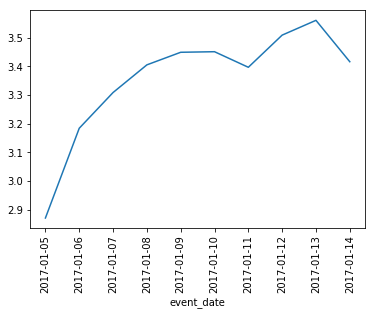

In [17]:
#Is the count of unique sessions per user constant during the week?
uniq_sessions_per_user=event_df.groupby("event_date").player_session_id.nunique()/event_df.groupby("event_date").player_id.nunique()
print(uniq_sessions_per_user)
uniq_sessions_per_user.plot(kind='line')
plt.xticks(rotation=90)